#### This notebook demonstrates the use of a reweighing pre-processing algorithm for bias mitigation


In [1]:
# load variables from computing environment
# import dill
# dill.load_session('random_forests_env.db')

In [2]:
# import gc

# # Forcefully close any lingering SQLite connections
# for obj in gc.get_objects():
#     if isinstance(obj, sqlite3.Connection):
#         print("Force-closing SQLite connection...")
#         obj.close()

# gc.collect()  # Clean up memory
# print("All SQLite connections forcefully closed.")


In [3]:
# save variables to computing environment

# import dill
# dill.dump_session('random_forests_env.db')

# import pickle

# # Save all variables in a dictionary
# variables_to_save = {key: value for key, value in globals().items() if not key.startswith("__")}

# # Save to a file
# with open("rf_env.pkl", "wb") as f:
#     pickle.dump(variables_to_save, f)

# import dill

# with open("rf_env.dill", "wb") as f:
#     dill.dump_session(f)



In [4]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.insert(0, '/home/jl0274/AIF360')
import numpy as np
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

from common_utils import compute_metrics

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [5]:
import aif360
aif360.__file__

'/home/jl0274/AIF360/aif360/__init__.py'

In [6]:
import pandas as pd
X_train = pd.read_pickle('/home/jl0274/Senior Thesis/X_train_norm.pkl')
y_train = pd.read_pickle('/home/jl0274/Senior Thesis/y_train.pkl')
X_val = pd.read_pickle('/home/jl0274/Senior Thesis/X_val_norm.pkl')
y_val = pd.read_pickle('/home/jl0274/Senior Thesis/y_val.pkl')
X_test = pd.read_pickle('/home/jl0274/Senior Thesis/X_test_norm.pkl')
y_test = pd.read_pickle('/home/jl0274/Senior Thesis/y_test.pkl')
print(X_train.isna().any().any())
print(y_train.isna().any().any())
print(X_val.isna().any().any())
print(y_val.isna().any().any())
print(X_test.isna().any().any())
print(y_test.isna().any().any())

False
False
False
False
False
False


In [7]:
y_train.shape

(827207,)

#### Load dataset and set options

In [8]:
## import dataset
dataset_used = "adult" # "adult", "german", "compas"
protected_attribute_used = 1 # 1, 2


if dataset_used == "adult":
#     dataset_orig = AdultDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_adult(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_adult(['race'])
    
elif dataset_used == "german":
#     dataset_orig = GermanDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_german(['sex'])
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        dataset_orig = load_preproc_data_german(['age'])
    
elif dataset_used == "compas":
#     dataset_orig = CompasDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_compas(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_compas(['race'])

all_metrics =  ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]

#random seed for calibrated equal odds prediction
np.random.seed(1)

standard dataset: is na? False


#### Split into train, and test

In [9]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

#### Clean up training data

In [10]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(827046, 21)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([0.])] [array([1.])]


#### Dataset feature names

['hoepa_status_2.0', 'hoepa_status_3.0', 'total_loan_costs', 'rate_spread', 'interest_rate', 'origination_charges', 'lender_credits', 'derived_dwelling_category_Single Family (1-4 Units):Site-Built', 'loan_term', 'discount_points', 'construction_method_2.0', 'tract_to_msa_income_percentage', 'combined_loan_to_value_ratio', 'tract_population', 'tract_minority_population_percent', 'property_value', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes', 'purchaser_type_1.0', 'income', 'sex']


#### Metric for original training data

In [11]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.053654


#### Train with and transform the original training data

In [12]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [13]:
### Testing 
assert np.abs(dataset_transf_train.instance_weights.sum()-dataset_orig_train.instance_weights.sum())<1e-6

#### Metric with the transformed training data

In [14]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


In [15]:
### Testing 
assert np.abs(metric_transf_train.mean_difference()) < 1e-6

## Gender Present

### Train classifier on original data

In [16]:
# classifier and predictions
X_train = dataset_orig_train.features
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

rf = RandomForestClassifier(n_estimators=550, max_features='sqrt', max_depth=None, min_samples_split=10, min_samples_leaf=1, bootstrap = True)
rf.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = rf.predict(X_train)

# positive class index
pos_ind = np.where(rf.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

#### Obtain scores for original validation and test sets

In [17]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = dataset_orig_valid_pred.features
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = rf.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = dataset_orig_test_pred.features
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = rf.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

### Find the optimal classification threshold from the validation set

In [18]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.9916
Optimal classification threshold (no reweighing) = 0.5940


### Predictions from the original test set at the optimal classification threshold

In [19]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

Classification threshold used = 0.5940


 62%|██████▏   | 62/100 [00:03<00:02, 16.25it/s]

Balanced accuracy = 0.9919
Statistical parity difference = 0.0490
Disparate impact = 1.0685
Average odds difference = -0.0002
Equal opportunity difference = -0.0026
Theil index = 0.0097


100%|██████████| 100/100 [00:06<00:00, 16.05it/s]


In [20]:
# inputs should be y_test, dataset_orig_test_pred.labels, dataset_orig_test_pred.scores respectively 
def accuracy_scores(y_true, preds, y_pred_scores, best_class_thresh):
    # F1 score
    y_pred = (y_pred_scores > best_class_thresh).astype(int)
    y_pred[y_pred == 1] = preds.favorable_label
    y_pred[y_pred == 0] = preds.unfavorable_label
    f1 = f1_score(y_true, y_pred)
    print(f"F1 Score: {f1:.4f}")
    # AUC
    auc = roc_auc_score(y_true, dataset_orig_test_pred.scores)
    print(f"ROC AUC Score: {auc:.4f}")
    
    return f1, auc
    
f1, auc = accuracy_scores(dataset_orig_test.labels, dataset_orig_test_pred, dataset_orig_test_pred.scores, best_class_thresh)

F1 Score: 0.9932
ROC AUC Score: 0.9995


In [21]:
# bias summary metrics
def bias_summary_metrics(gender_col, target):
    # test whether loan approval significantly depends on gender
    gender_col = pd.Series(gender_col)  # Convert gender to categorical
    target = pd.Series(target.ravel())

    # Create a contingency table
    contingency_table = pd.crosstab(gender_col, target)
    
    # Perform the Chi-Square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"Chi-Square Statistic: {chi2}")
    print(f"P-value: {p_value}")
    
    if p_value < 0.05:
        print("There is a significant association between gender and loan approval.")
    else:
        print("There is no significant association between gender and loan approval.")

    # test whether there's a significant difference in loan approval proportions across men vs women

    # Count of approvals for men and women
    men_approved = sum((gender_col == 0) & (target == 1))
    women_approved = sum((gender_col == 1) & (target == 1))
    
    # Total number of applicants in each group
    men_total = sum(gender_col == 0)
    women_total = sum(gender_col == 1)
    
    # Run the Z-test
    count = [men_approved, women_approved]
    nobs = [men_total, women_total]
    stat, p_value = proportions_ztest(count, nobs)
    
    print(f"Z-statistic: {stat}")
    print(f"P-value: {p_value:10e}")
    
    if p_value < 0.05:
        print("There is a significant difference in loan approval rates between men and women.")
    else:
        print("There is no significant difference in loan approval rates between men and women.")

    men_approved_prop = men_approved/men_total
    women_approved_prop = women_approved/women_total
    print(f'male approval rate: {men_approved_prop}')
    print(f'female approval rate: {women_approved_prop}')
    

In [22]:
bias_summary_metrics(X_test[:, -1], y_test)

Chi-Square Statistic: 412.63761787951364
P-value: 9.772129979545818e-92
There is a significant association between gender and loan approval.
Z-statistic: 20.319086499593713
P-value: 8.718357e-92
There is a significant difference in loan approval rates between men and women.
male approval rate: 0.743819971773181
female approval rate: 0.6987461932223158


#### Display results for all thresholds

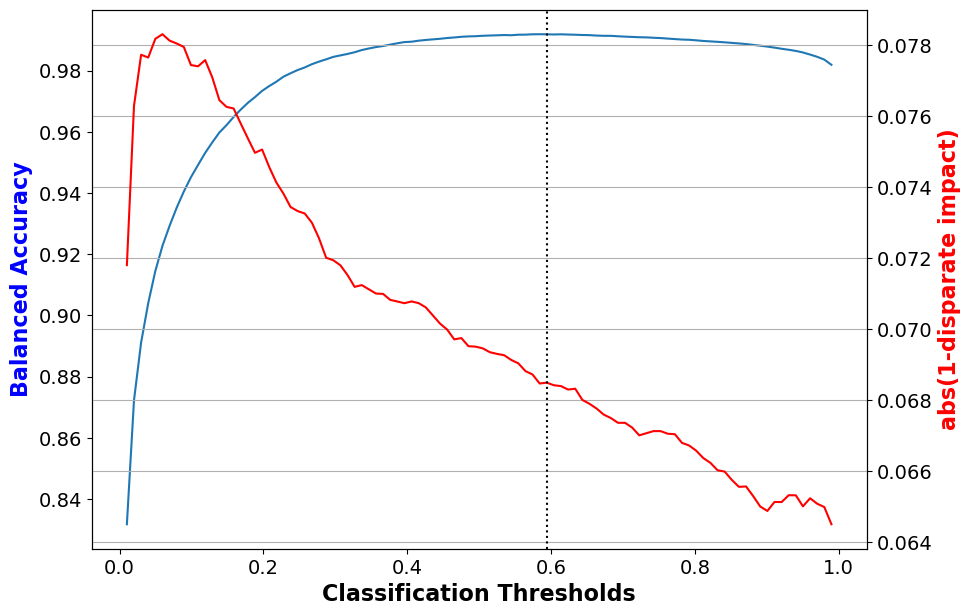

In [23]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig("rf-reweighing-di")

plt.show()

```abs(1-disparate impact)``` must be small (close to 0) for classifier predictions to be fair.

However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

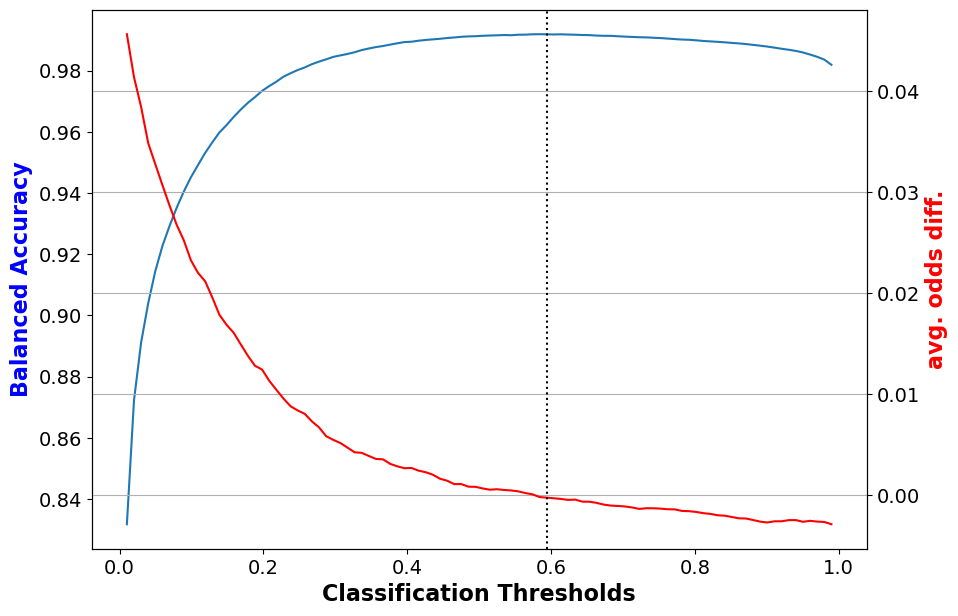

In [24]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig("rf-reweighing-aodds")

plt.show()

```average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv))``` must be close to zero for the classifier to be fair.

However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

### Train classifier on transformed data

In [25]:
X_train = dataset_transf_train.features
y_train = dataset_transf_train.labels.ravel()

rf = RandomForestClassifier(n_estimators=550, max_features='sqrt', max_depth=None, min_samples_split=10, min_samples_leaf=1, bootstrap = True)
rf.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = rf.predict(X_train)

#### Obtain scores for transformed test set

In [26]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = dataset_transf_test_pred.features
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = rf.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

### Predictions from the transformed test set at the optimal classification threshold

In [27]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

Classification threshold used = 0.5940


 62%|██████▏   | 62/100 [00:03<00:02, 16.44it/s]

Balanced accuracy = 0.9919
Statistical parity difference = 0.0487
Disparate impact = 1.0680
Average odds difference = -0.0006
Equal opportunity difference = -0.0029
Theil index = 0.0097


100%|██████████| 100/100 [00:06<00:00, 16.33it/s]


In [28]:
f1, auc = accuracy_scores(dataset_orig_test.labels, dataset_transf_test_pred, dataset_transf_test_pred.scores, best_class_thresh)

F1 Score: 0.9932
ROC AUC Score: 0.9995


In [29]:
bias_summary_metrics(X_test[:, -1], y_test)

Chi-Square Statistic: 414.0954139216384
P-value: 4.706203539334503e-92
There is a significant association between gender and loan approval.
Z-statistic: 20.354937153904263
P-value: 4.197887e-92
There is a significant difference in loan approval rates between men and women.
male approval rate: 0.743819971773181
female approval rate: 0.6986651979524395


#### Display results for all thresholds

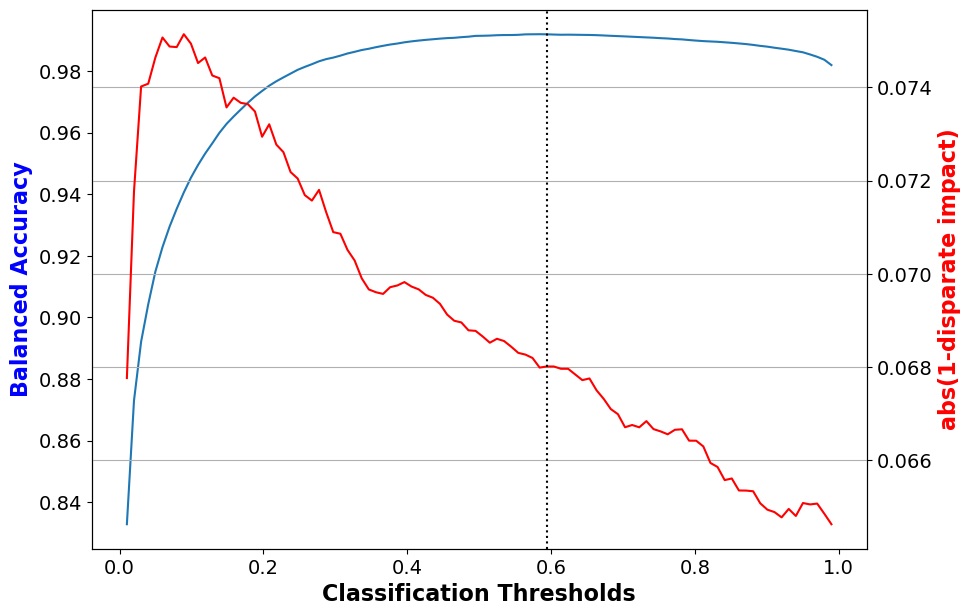

In [32]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig("rf-reweighing-di2")

plt.show()

```abs(1-disparate impact)``` must be small (close to 0) for classifier predictions to be fair.

For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case.
This implies fairness.

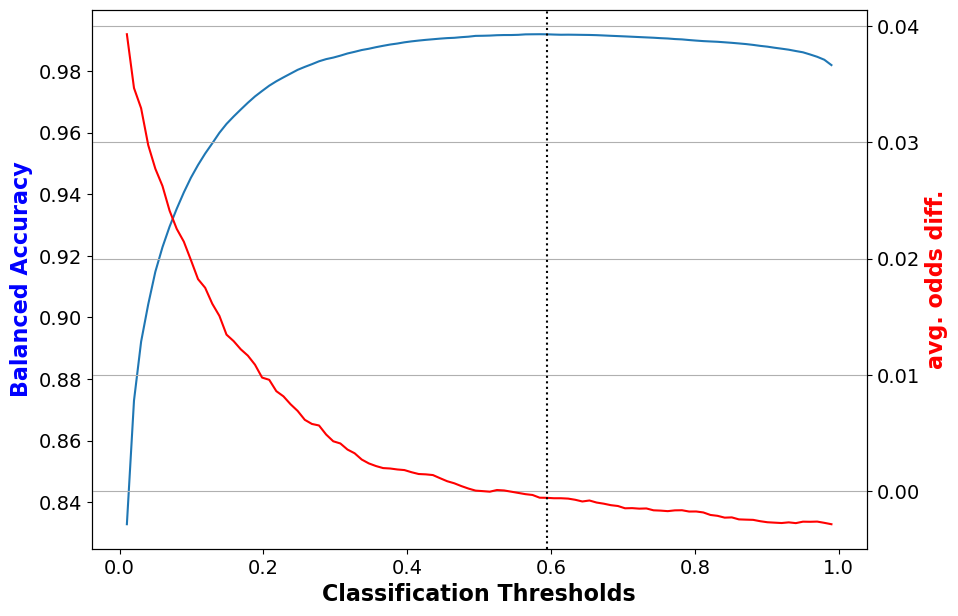

In [33]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig("rf-reweighing-aodds2")

plt.show()

```average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv))``` must be close to zero for the classifier to be fair.

For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case.
This implies fairness.

# Summary of Results
We show the optimal classification thresholds, and the fairness and accuracy metrics.

### Classification Threshold

0.7326

In [34]:
dis_table = f"""
### Fairness Metric: Disparate impact, Accuracy Metric: Balanced accuracy

#### Performance

|Sex (Acc-Bef)|Sex (Acc-Aft)|Sex (Fair-Bef)|Sex (Fair-Aft)|
|-|-|-|-|
|{round(metric_test_bef['Balanced accuracy'], 5)}|{round(metric_test_aft['Balanced accuracy'], 5)}|{round(metric_test_bef['Disparate impact'], 5)}|{round(metric_test_aft['Disparate impact'], 5)}|
"""

# Render the Markdown table
display(Markdown(dis_table))


### Fairness Metric: Disparate impact, Accuracy Metric: Balanced accuracy

#### Performance

|Sex (Acc-Bef)|Sex (Acc-Aft)|Sex (Fair-Bef)|Sex (Fair-Aft)|
|-|-|-|-|
|0.98192|0.98192|1.06451|1.06463|


In [35]:
odds_table = f"""
### Fairness Metric: Average odds difference, Accuracy Metric: Balanced accuracy

#### Performance

|Sex (Acc-Bef)|Sex (Acc-Aft)|Sex (Fair-Bef)|Sex (Fair-Aft)|
|-|-|-|-|
|{round(metric_test_bef['Balanced accuracy'], 5)}|{round(metric_test_aft['Balanced accuracy'], 5)}|{round(metric_test_bef['Average odds difference'], 5)}|{round(metric_test_aft['Average odds difference'], 5)}|
"""

# Render the Markdown table
display(Markdown(odds_table))


### Fairness Metric: Average odds difference, Accuracy Metric: Balanced accuracy

#### Performance

|Sex (Acc-Bef)|Sex (Acc-Aft)|Sex (Fair-Bef)|Sex (Fair-Aft)|
|-|-|-|-|
|0.98192|0.98192|-0.00287|-0.00283|


## Gender Not Present

### Train classifier on original data

In [36]:
gender_col = X_test[:, -1]

In [37]:
# classifier and predictions
X_train = dataset_orig_train.features
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

rf = RandomForestClassifier(n_estimators=550, max_features='sqrt', max_depth=None, min_samples_split=10, min_samples_leaf=1, bootstrap = True)
rf.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = rf.predict(X_train)

# positive class index
pos_ind = np.where(rf.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

#### Obtain scores for original validation and test sets

In [38]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = dataset_orig_valid_pred.features
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = rf.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = dataset_orig_test_pred.features
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = rf.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

### Find the optimal classification threshold from the validation set

In [39]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.9915
Optimal classification threshold (no reweighing) = 0.6237


### Predictions from the original test set at the optimal classification threshold

In [40]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

Classification threshold used = 0.6237


 63%|██████▎   | 63/100 [01:04<00:37,  1.02s/it]

Balanced accuracy = 0.9918
Statistical parity difference = 0.0489
Disparate impact = 1.0684
Average odds difference = -0.0004
Equal opportunity difference = -0.0027
Theil index = 0.0103


100%|██████████| 100/100 [01:42<00:00,  1.02s/it]


In [41]:
f1, auc = accuracy_scores(dataset_orig_test.labels, dataset_orig_test_pred, dataset_orig_test_pred.scores, best_class_thresh)

F1 Score: 0.9929
ROC AUC Score: 0.9995


In [42]:
bias_summary_metrics(gender_col, y_test)

Chi-Square Statistic: 413.1825343104497
P-value: 7.436643081040384e-92
There is a significant association between gender and loan approval.
Z-statistic: 20.332493660243085
P-value: 6.634367e-92
There is a significant difference in loan approval rates between men and women.
male approval rate: 0.7436641181716641
female approval rate: 0.6985518045746129


#### Display results for all thresholds

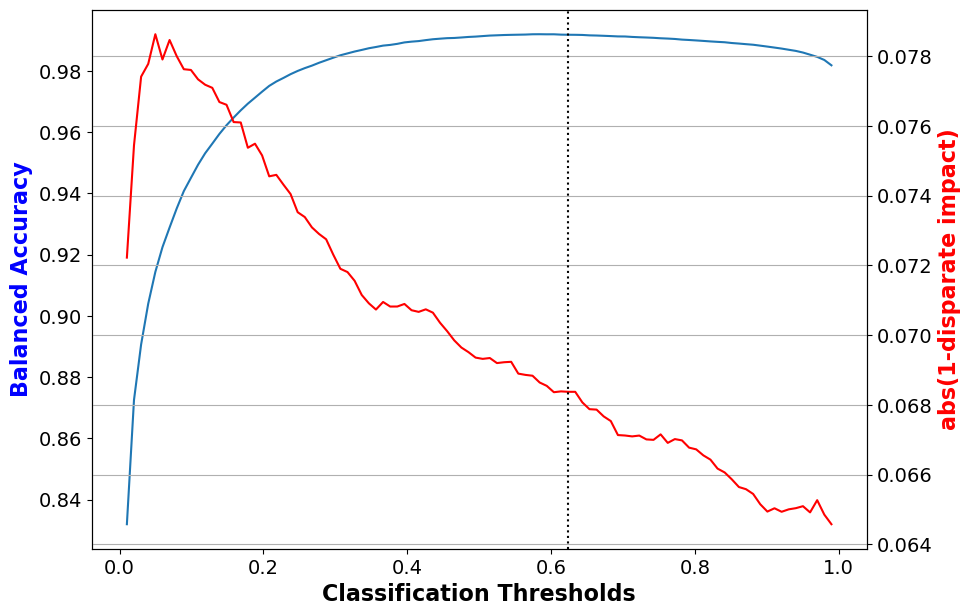

In [43]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig("rf-reweighing-di-nogen")

plt.show()

```abs(1-disparate impact)``` must be small (close to 0) for classifier predictions to be fair.

However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

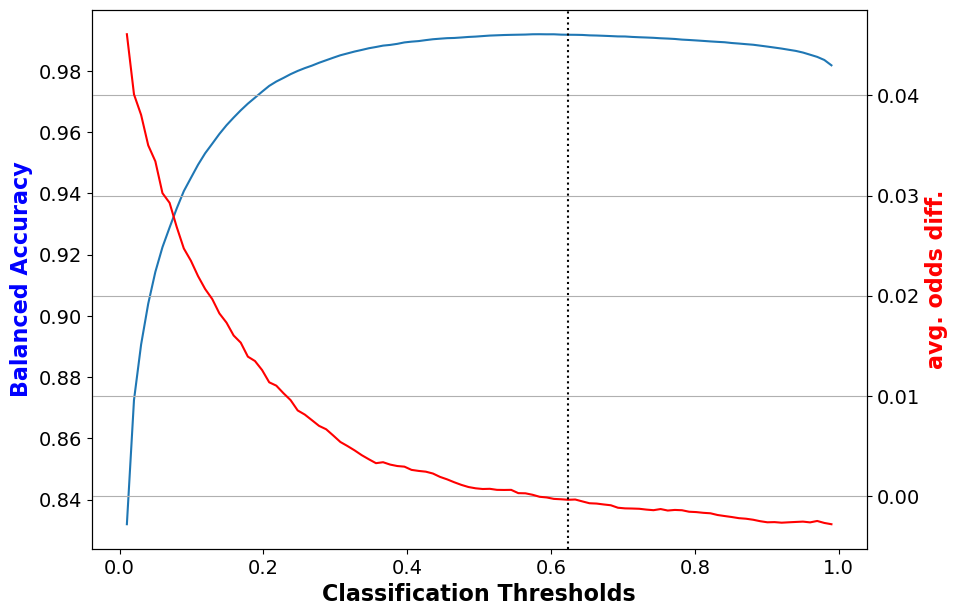

In [44]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig("rf-reweighing-aodds-nogen")

plt.show()

```average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv))``` must be close to zero for the classifier to be fair.

However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

### Train classifier on transformed data

In [45]:
X_train = dataset_transf_train.features
y_train = dataset_transf_train.labels.ravel()

rf = RandomForestClassifier(n_estimators=550, max_features='sqrt', max_depth=None, min_samples_split=10, min_samples_leaf=1, bootstrap = True)
rf.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = rf.predict(X_train)

#### Obtain scores for transformed test set

In [46]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = dataset_transf_test_pred.features
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = rf.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

### Predictions from the transformed test set at the optimal classification threshold

In [47]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

Classification threshold used = 0.6237


 63%|██████▎   | 63/100 [01:04<00:38,  1.03s/it]

Balanced accuracy = 0.9917
Statistical parity difference = 0.0486
Disparate impact = 1.0680
Average odds difference = -0.0006
Equal opportunity difference = -0.0030
Theil index = 0.0104


100%|██████████| 100/100 [01:42<00:00,  1.03s/it]


In [48]:
f1, auc = accuracy_scores(dataset_orig_test.labels, dataset_transf_test_pred, dataset_transf_test_pred.scores, best_class_thresh)

F1 Score: 0.9928
ROC AUC Score: 0.9995


In [49]:
bias_summary_metrics(gender_col, y_test)

Chi-Square Statistic: 410.09473350547717
P-value: 3.495468762344907e-91
There is a significant association between gender and loan approval.
Z-statistic: 20.256401097311432
P-value: 3.119479e-91
There is a significant difference in loan approval rates between men and women.
male approval rate: 0.744131678976215
female approval rate: 0.699215965787598


#### Display results for all thresholds

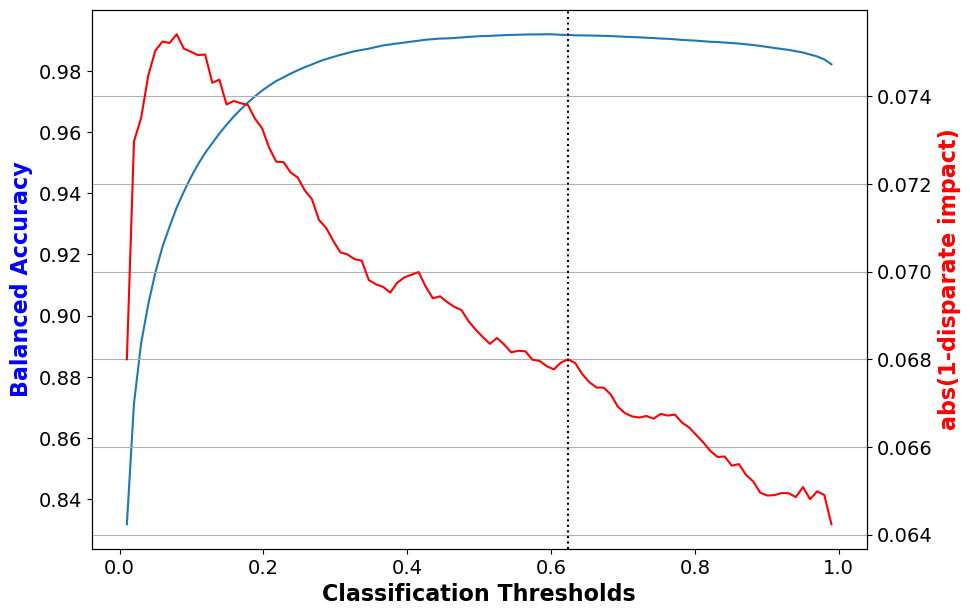

In [50]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig("rf-reweighing-di2-nogen")

plt.show()

```abs(1-disparate impact)``` must be small (close to 0) for classifier predictions to be fair.

For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case.
This implies fairness.

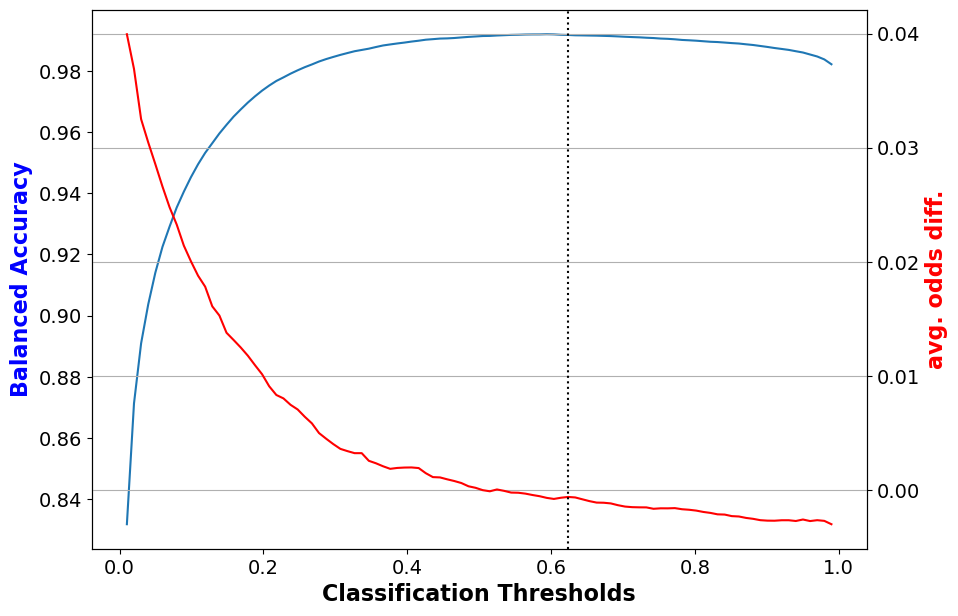

In [51]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig("rf-reweighing-aodds2-nogen")

plt.show()

```average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv))``` must be close to zero for the classifier to be fair.

For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case.
This implies fairness.